In [1]:
import fastf1 as ff1
from fastf1 import plotting
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import pandas as pd

In [4]:
# Setup plotting
plotting.setup_mpl()

# Enable the cache
ff1.Cache.enable_cache('../cache') 

# Get rid of some pandas warnings that are not relevant for us at the moment
pd.options.mode.chained_assignment = None 

NotADirectoryError: Cache directory does not exist! Please check for typos or create it first.

In [7]:
# Enable the cache by providing the name of the cache folder
ff1.Cache.enable_cache('cache') 

In [8]:
# Load the session data
race = ff1.get_session(2021, 'Monza', 'R')

In [9]:

# Get the laps
laps = race.load_laps(with_telemetry=True)

/home/ubuntu/.local/lib/python3.10/site-packages/fastf1/core.py:1220: FutureWarning: `Session.load_laps` is deprecated and will beremoved in a future version.
Use `Session.load` instead.
  warnings.warn("`Session.load_laps` is deprecated and will be"
core           INFO 	Loading data for Italian Grand Prix - Race [v2.3.0]
api            INFO 	No cached data found for driver_info. Loading data...
api            INFO 	Fetching driver list...
api            INFO 	Data has been written to cache!
api            INFO 	No cached data found for timing_data. Loading data...
api            INFO 	Fetching timing data...
api            INFO 	Parsing timing data...
api            INFO 	Data has been written to cache!
api            INFO 	No cached data found for timing_app_data. Loading data...
api            INFO 	Fetching timing app data...
api            INFO 	Data has been written to cache!
core           INFO 	Processing timing data...
api            INFO 	No cached data found for session_stat

In [10]:
# Get laps of the drivers (BOT and HAM)
laps_ric = laps.pick_driver('RIC')
laps_ver = laps.pick_driver('VER')

In [11]:
# We are only analyzing stint 1, so select that one
laps_ric = laps_ric.loc[laps_ric['Stint'] == 1]
laps_ver = laps_ver.loc[laps_ver['Stint'] == 1]

In [12]:
laps_ric['RaceLapNumber'] = laps_ric['LapNumber'] - 1
laps_ver['RaceLapNumber'] = laps_ver['LapNumber'] - 1

In [13]:
full_distance_ver_ric = pd.DataFrame()
summarized_distance_ver_ric = pd.DataFrame()

In [14]:
for lap in laps_ver.iterlaps():
    telemetry = lap[1].get_car_data().add_distance().add_driver_ahead()
    
    # Only run this loop when driver ahead is RIC, otherwise we compare wrong distance gaps
    telemetry = telemetry.loc[telemetry['DriverAhead'] == "3"]
    
    if len(telemetry) != 0:
        # Full distance
        lap_telemetry = telemetry[['Distance', 'DistanceToDriverAhead']]
        lap_telemetry.loc[:, 'Lap'] = lap[0] + 1

        full_distance_ver_ric = full_distance_ver_ric.append(lap_telemetry)

        # Average / median distance
        distance_mean = np.nanmean(telemetry['DistanceToDriverAhead'])
        distance_median = np.nanmedian(telemetry['DistanceToDriverAhead'])

        summarized_distance_ver_ric = summarized_distance_ver_ric.append({
            'Lap': lap[0] + 1,
            'Mean': distance_mean,
            'Median': distance_median
        }, ignore_index = True)

/tmp/ipykernel_868/1663263901.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lap_telemetry.loc[:, 'Lap'] = lap[0] + 1
/tmp/ipykernel_868/1663263901.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  full_distance_ver_ric = full_distance_ver_ric.append(lap_telemetry)
/tmp/ipykernel_868/1663263901.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summarized_distance_ver_ric = summarized_distance_ver_ric.append({
/tmp/ipykernel_868/1663263901.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

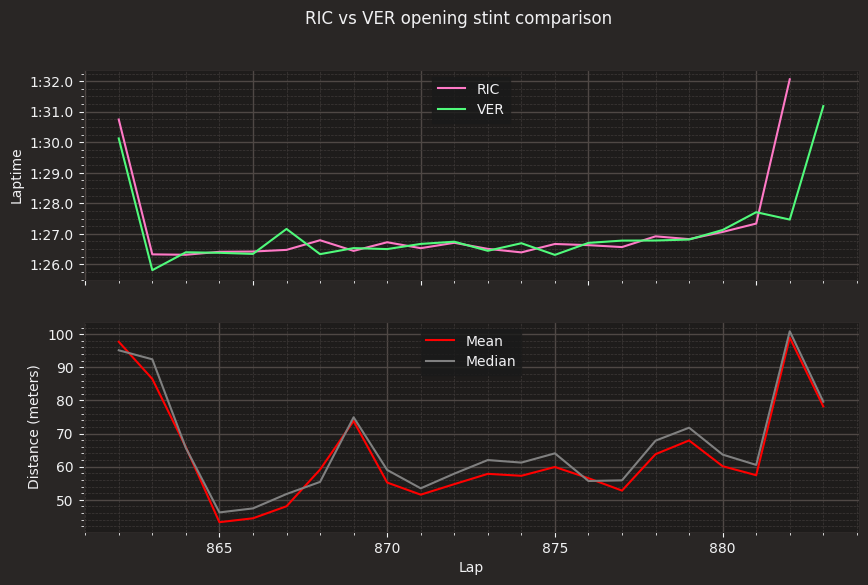

In [15]:
plt.rcParams['figure.figsize'] = [10, 6]

fig, ax = plt.subplots(2)
fig.suptitle("RIC vs VER opening stint comparison")

ax[0].plot(laps_ric['RaceLapNumber'], laps_ric['LapTime'], label='RIC')
ax[0].plot(laps_ver['RaceLapNumber'], laps_ver['LapTime'], label='VER')
ax[0].set(ylabel='Laptime', xlabel='Lap')
ax[0].legend(loc="upper center")

ax[1].plot(summarized_distance_ver_ric['Lap'], summarized_distance_ver_ric['Mean'], label='Mean', color='red')
ax[1].plot(summarized_distance_ver_ric['Lap'], summarized_distance_ver_ric['Median'], label='Median', color='grey')
ax[1].set(ylabel='Distance (meters)', xlabel='Lap')
ax[1].legend(loc="upper center")

# Hide x labels and tick labels for top plots and y ticks for right plots.
for a in ax.flat:
    a.label_outer()

plt.show()